In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!7z x "/content/gdrive/My Drive/cursDeeplearningFMI/data.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/cursDeeplearningFMI/                                                       1 file, 12064934 bytes (12 MiB)

Extracting archive: /content/gdrive/My Drive/cursDeeplearningFMI/data.zip
--
Path = /content/gdrive/My Drive/cursDeeplearningFMI/data.zip
Type = zip
Physical Size = 12064934

  0%    Everything is Ok

Folders: 7
Files: 828
Size:       12519210
Compressed: 12064934


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision.utils as utils
import cv2
import time
import os
import copy
import pdb;
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
data_dir = "./data/"
num_classes = 2

batch_size = 8
num_epochs = 200
feature_extract = True

In [ ]:
class Attention(nn.Module):
    def __init__(self, in_features):
        super(Attention, self).__init__()
        self.op = nn.Sequential(
                    nn.Conv2d(in_channels=in_features, out_channels=64, kernel_size=3, padding=1),
                    nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
                    nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, padding=0))
    def forward(self, l):
        N, C, W, H = l.size()
        c = self.op(l)
        a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        return a.view(N,1,W,H), g

class ModifyVGG(nn.Module):
    def __init__(self, im_size, num_classes):
        super(ModifyVGG,self).__init__()
        vgg_model = models.vgg16(pretrained=True)		
        
        # everything before layer 4
        self.before_att = nn.Sequential(*list(vgg_model.features.children())[:4])
        # added layer
        self.attention1 = Attention(in_features=64)
        self.attention2 = Attention(in_features=128)
        self.attention3 = Attention(in_features=256)
        # everything after layer 4
        self.after_att = nn.Sequential(*list(vgg_model.features.children())[4:]) 
        self.avg_pool = vgg_model.avgpool
        self.classifier = nn.Sequential(*list(vgg_model.classifier.children()))
    def forward(self,x):
      # run vgg before layer 4
      x = self.before_att(x)
      # run added layer
      c1, x = self.attention1(x)
      # run vgg from layer 5 -> 9
      x = self.after_att[:5](x)
      # run added layer
      c2, x = self.attention2(x)
      # run vgg from layer 10 -> 17
      x = self.after_att[5:12](x)
      # run added layer
      c3, x = self.attention3(x)
      x = self.after_att[12:](x)
      # run vgg from layer 18
      x = self.avg_pool(x)
      x = x.view((x.shape[0],x.shape[1]*x.shape[2]*x.shape[3]))
      x = self.classifier(x)
      return x, c1, c2, c3

In [ ]:
model_nou = ModifyVGG(224,2)
model_nou.children

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


<bound method Module.children of ModifyVGG(
  (before_att): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (attention1): Attention(
    (op): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (attention2): Attention(
    (op): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (attention3): Attention(
    (op): Sequential(
      (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 16, kernel_size=(3, 3),

In [ ]:
#Change the number of output classes
model_nou.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
model = nn.DataParallel(model_nou)
model_nou.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

## Train and validate the model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_attention=False):
    since = time.time()
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if(is_attention):
                        outputs, _, _, _= model(inputs)
                    else:
                        outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

## Improve the dataset

In [ ]:
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5,contrast=0.5),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor()
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_ft = model
model_ft = model_ft.to(device)
# what do I have to learn?
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

	 module.before_att.0.weight
	 module.before_att.0.bias
	 module.before_att.2.weight
	 module.before_att.2.bias
	 module.attention1.op.0.weight
	 module.attention1.op.0.bias
	 module.attention1.op.1.weight
	 module.attention1.op.1.bias
	 module.attention1.op.2.weight
	 module.attention1.op.2.bias
	 module.attention2.op.0.weight
	 module.attention2.op.0.bias
	 module.attention2.op.1.weight
	 module.attention2.op.1.bias
	 module.attention2.op.2.weight
	 module.attention2.op.2.bias
	 module.attention3.op.0.weight
	 module.attention3.op.0.bias
	 module.attention3.op.1.weight
	 module.attention3.op.1.bias
	 module.attention3.op.2.weight
	 module.attention3.op.2.bias
	 module.after_att.1.weight
	 module.after_att.1.bias
	 module.after_att.3.weight
	 module.after_att.3.bias
	 module.after_att.6.weight
	 module.after_att.6.bias
	 module.after_att.8.weight
	 module.after_att.8.bias
	 module.after_att.10.weight
	 module.after_att.10.bias
	 module.after_att.13.weight
	 module.after_att.13.bias
	 

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, histv, histt = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_attention = True)

torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size([8, 64, 224, 224])
torch.Size([8, 128, 112, 112])
torch.Size([8, 256, 56, 56])
torch.Size

KeyboardInterrupt: ignored

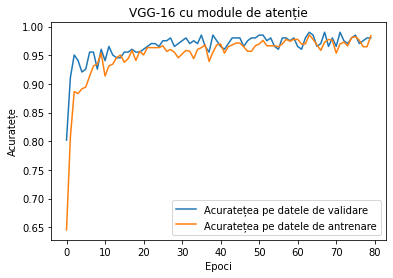

In [ ]:
plt.plot(histv,label='Acuratețea pe datele de validare')
plt.plot(histt,label='Acuratețea pe datele de antrenare')
plt.xlabel('Epoci')
plt.ylabel('Acuratețe')
plt.legend()
plt.title('VGG-16 cu module de atenție')
plt.savefig('graph.png')
plt.show()

In [ ]:
contor = 0
which_image = 7
image_test = []
for input, target in dataloaders_dict['validation']:
  if(contor == which_image = 7):
    break
  input = input.to(device)
  contor += 1

In [ ]:
torch.save(model_ft.state_dict(), "trained_model")

In [ ]:
predicted, c1, c2, c3 = model(input)

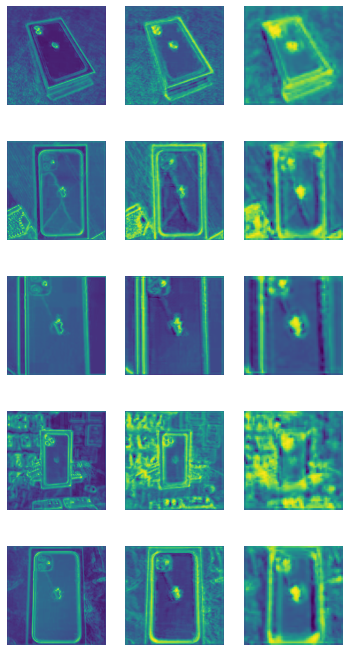

In [ ]:
num_image = 0
fig=plt.figure(figsize=(6,12))
columns = 3
rows = 5
fig.add_subplot(rows, columns, 1)
plt.imshow(c1.cpu().detach().numpy()[5,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(c2.cpu().detach().numpy()[5,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(c3.cpu().detach().numpy()[5,0,:,:])
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(c1.cpu().detach().numpy()[1,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 5)
plt.imshow(c2.cpu().detach().numpy()[1,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 6)
plt.imshow(c3.cpu().detach().numpy()[1,0,:,:])
plt.axis('off')

fig.add_subplot(rows, columns, 7)
plt.imshow(c1.cpu().detach().numpy()[2,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 8)
plt.imshow(c2.cpu().detach().numpy()[2,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 9)
plt.imshow(c3.cpu().detach().numpy()[2,0,:,:])
plt.axis('off')

fig.add_subplot(rows, columns, 10)
plt.imshow(c1.cpu().detach().numpy()[3,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 11)
plt.imshow(c2.cpu().detach().numpy()[3,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 12)
plt.imshow(c3.cpu().detach().numpy()[3,0,:,:])
plt.axis('off')

fig.add_subplot(rows, columns, 13)
plt.imshow(c1.cpu().detach().numpy()[4,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 14)
plt.imshow(c2.cpu().detach().numpy()[4,0,:,:])
plt.axis('off')
fig.add_subplot(rows, columns, 15)
plt.imshow(c3.cpu().detach().numpy()[4,0,:,:])

plt.axis('off')
plt.show()

# VGG-16 with frozen layers


In [ ]:
model = models.vgg16(pretrained=True)

In [ ]:
def set_parameter_requires_grad(model):
      for param in model.parameters():
          param.requires_grad = False

In [ ]:
model_ft = models.vgg16(pretrained=True)
# Freeze model weights
set_parameter_requires_grad(model_ft)
model_ft.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256, bias=True), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2, bias=True),                   
                      nn.LogSoftmax(dim=1))
model_ft.classifier

# Add on classifier


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax()
  )
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.1, momentum=0.9)

Params to learn:
	 classifier.6.0.weight
	 classifier.6.0.bias
	 classifier.6.3.weight
	 classifier.6.3.bias


In [ ]:
model_ft = model_ft.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, histv, histt = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_attention=False)

Epoch 0/199
----------
train Loss: 0.6576 Acc: 0.6022
validation Loss: 0.6747 Acc: 0.5644

Epoch 1/199
----------


KeyboardInterrupt: ignored

In [ ]:
plt.plot(histv[:100],label='Acuratețea pe validare')
plt.plot(histt[:100],label='Acuratețea pe antrenare')
plt.xlabel('Epoci')
plt.ylabel('Acuratețe')
plt.legend()
plt.title('VGG-16 cu reglaj fin')
plt.savefig('graph.png')
plt.show()

In [ ]:
contor = 0
which_image = 7
image_test = []
for input, target in image_datasets['validation']:
  if(contor == which_image):
    break
  input = input.to(device)
  contor += 1

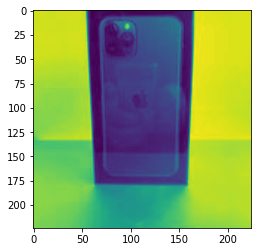

In [ ]:
plt.imshow(input[0,:,:])



In [ ]:
input[1,:,:]

tensor([[0.8431, 0.8431, 0.8431,  ..., 0.8353, 0.8353, 0.8353],
        [0.8431, 0.8431, 0.8431,  ..., 0.8353, 0.8353, 0.8353],
        [0.8431, 0.8431, 0.8431,  ..., 0.8353, 0.8353, 0.8353],
        ...,
        [0.7451, 0.7451, 0.7451,  ..., 0.7725, 0.7725, 0.7725],
        [0.7451, 0.7451, 0.7451,  ..., 0.7686, 0.7686, 0.7725],
        [0.7451, 0.7451, 0.7451,  ..., 0.7686, 0.7686, 0.7686]])

In [ ]:
import matplotlib.pyplot as plt
for batch_idx, (inputs, labels) in enumerate(dataloaders_dict['train']):
     plt.figure()
     inputs = inputs.permute(1, 2, 0)
     plt.imshow(inputs.numpy())
     plt.show()

RuntimeError: ignored

<Figure size 432x288 with 0 Axes>